#Install required packages

In [1]:
!pip install matplotlib pandas torch torchmetrics scikit-learn

# Import all libraries and models

In [ ]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
import json
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from models import ResNet50, ResNet50BiLSTMAttention, ResNet34BiLSTMAttention, ResNetGRUModel, ResNetLSTMFlatten, ResNet34BiLSTMAttentionDropout

import torch.optim as optim
from collections import OrderedDict

In [2]:
import pickle
import random
from sklearn.model_selection import train_test_split
import os

#Implemented seeding 
def seed_functions(seed):
	"""Seeds functions from numpy and torch."""
	np.random.seed(seed)
	random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
	os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 37
seed_functions(SEED)

# Import the dataset and store it in 'SequenceDataset class' under variable name 'dataset'

# Save path to dataset under variable name 'root_dir'

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, npy_file_paths, labels):
        """
        Args:
            npy_file_paths (list of str): List of file paths for .npy files containing the sequences.
            labels (list): List of labels corresponding to each sequence.
        """
        # Load the sequences and labels
        self.data = [torch.tensor(np.load(file_path)) for file_path in npy_file_paths]
        self.labels = torch.tensor(labels, dtype=torch.float)  # Convert the labels to a tensor

    def __len__(self):
        # Dataset contains as many samples as the number of npy files
        return len(self.data)

    def __getitem__(self, idx):
        # Return the sequence data and its corresponding label
        return self.data[idx], self.labels[idx].long()

        

# Storing of dataset into class
npy_file_paths = []
labels = []

root_dir = '../data/mel'   # SAVE PATH TO DATASET HERE

languages = sorted([d for d in os.listdir(root_dir) if d != '.ipynb_checkpoints' and os.path.isdir(os.path.join(root_dir, d))])
print(languages)
num_languages = len(languages)

for i, lang_dir in enumerate(languages):
    lang_path = os.path.join(root_dir, lang_dir)
    if not os.path.isdir(lang_path):
        continue  # Skip non-directory files

    # List all .npy files
    file_names = os.listdir(lang_path)
    full_paths = [os.path.join(lang_path, f) for f in file_names]

    # Extend lists
    npy_file_paths.extend(full_paths)
    labels.extend([i] * len(full_paths))


dataset = SequenceDataset(npy_file_paths, labels)  # THIS IS THE FINAL DATASET

['arabic', 'chinese', 'english', 'french', 'hindi', 'indonesian', 'spanish', 'thai', 'vietnamese']


## Function to split dataset, used to split into train, valid and test dataloaders (no changes need to be made)

In [ ]:
def split_data(dataset):
    # Split dataset into train, validation, and test sets
    indices = np.arange(len(dataset))
    np.random.seed(SEED)
    np.random.shuffle(indices)

    train_size = int(0.7 * len(indices))
    valid_size = (len(indices) - train_size) // 2
    test_size = len(indices) - train_size - valid_size

    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size+valid_size]
    test_indices = indices[train_size +valid_size:]

    train_data = torch.utils.data.Subset(dataset, train_indices)
    valid_data = torch.utils.data.Subset(dataset, valid_indices)
    test_data = torch.utils.data.Subset(dataset, test_indices)

    # Define a seed worker for DataLoader
    def seed_worker(worker_id):
        worker_seed = SEED + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    # Define generators for DataLoader
    generator = torch.Generator().manual_seed(SEED)

    batch_size = 128
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                              generator=generator, worker_init_fn=seed_worker, drop_last=True)
    valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False,
                              generator=generator, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False,
                             generator=generator, worker_init_fn=seed_worker)

    return train_loader, valid_loader, test_loader

    return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = split_data(dataset)

# Trainer class. Has the option for gradual unfreezing of layers or unfreeze all layers at once. Unfreeze epochs refers to the epoch number at which the next layer will be unfrozen if gradual unfreezing is enabled. Take note of arguments. (no changes need to be made)

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, valid_loader, test_loader, num_classes=2, num_epochs=10, gradual_unfreezing=False, unfreeze_epochs=[], patience=3, save_dir='checkpoints'):
        self.device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.gradual_unfreezing = gradual_unfreezing
        self.unfreeze_epochs = (
            [] if unfreeze_epochs is None or not gradual_unfreezing 
            else sorted(unfreeze_epochs, reverse=True)  # Unfreeze last layers first
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)
        self.optimizer.zero_grad()
        self.accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(self.device)
        self.best_val_loss = float('inf')
        self.best_model_state = None
        self.best_epoch = 0
        self.l2_lambda = 0.001
        self.layer_groups = self._group_layers()
        self._initialize_requires_grad()

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        model_name = model.__class__.__name__
        self.model_save_dir = os.path.join(save_dir, model_name)
        os.makedirs(self.model_save_dir, exist_ok=True)

        self.patience = patience
        self.early_stopping_counter = 0
        self._save_config() #save the configs of the model in config.json


    def _group_layers(self):
        layer_dict = OrderedDict()
        for name, param in self.model.named_parameters():
            layer_name = name.split(".")[0]  # Extract top-level layer name
            if layer_name not in layer_dict:
                layer_dict[layer_name] = []
            layer_dict[layer_name].append(param)
        return list(layer_dict.items())  # List of (layer_name, parameters) tuples

    def _initialize_requires_grad(self):
        if not self.gradual_unfreezing:  # If gradual_unfreezing is False, make all parameters trainable
            for param in self.model.parameters():
                param.requires_grad = True
        else:
            for layer_name, params in self.layer_groups:
                for param in params:
                    param.requires_grad = False
            self._unfreeze_layer() #unfreeze fc layer

    def _unfreeze_layer_by_epoch(self, epoch):
        if epoch in self.unfreeze_epochs:
            self._unfreeze_layer()
    
    def _unfreeze_layer(self):
        if self.layer_groups:
            layer_name, params = self.layer_groups.pop()  # Unfreeze last remaining layer
            for param in params:
                param.requires_grad = True
        
    def train(self, start_epoch=0):
        for epoch in range(start_epoch, start_epoch + self.num_epochs):
            self.model.train()

            epoch_loss = 0.0
            epoch_accuracy = 0.0

            self._unfreeze_layer_by_epoch(epoch)
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.float().to(self.device), targets.to(self.device)
                pred = self.model(inputs)
                print("train:", pred, targets)
                loss = self.criterion(pred, targets)
                
                # L2 Regularization
                l2_norm = sum(p.pow(2).sum() for p in self.model.parameters())
                loss += self.l2_lambda * l2_norm
                
                self.accuracy_metric.update(pred, targets)
                accuracy = self.accuracy_metric.compute()
                self.accuracy_metric.reset()
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()
                epoch_accuracy += accuracy.item()
            
            avg_loss = epoch_loss / len(self.train_loader)
            avg_accuracy = epoch_accuracy / len(self.train_loader)

            val_loss, val_accuracy = self.validate()
            self.train_losses.append(float(avg_loss))
            self.train_accuracies.append(float(avg_accuracy))
            self.val_losses.append(float(val_loss))
            self.val_accuracies.append(float(val_accuracy))

            # Save current model
            torch.save(self.model.state_dict(), os.path.join(self.model_save_dir, f'model_epoch_{epoch+1}.pt'))

            # Best model logic
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_state = self.model.state_dict()
                self.best_epoch = epoch + 1
                self.early_stopping_counter = 0
                self._save_best_model()
                torch.save(self.best_model_state, os.path.join(self.model_save_dir, 'best_model.pt'))
            else:
                self.early_stopping_counter += 1

            print(f'Epoch [{epoch+1}/{self.num_epochs}], Train Loss: {avg_loss:.4f}, Train Acc: {avg_accuracy:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Patience Counter: {self.early_stopping_counter}')

            # Check early stopping
            if self.early_stopping_counter >= self.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        self._load_best_model()
        self.test()

    def validate(self):
        self.model.eval()
        total_loss = 0.0
        total_accuracy = 0.0

        with torch.no_grad():
            for inputs, targets in self.valid_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                pred = self.model(inputs)
                loss = self.criterion(pred, targets).item()
                self.accuracy_metric.update(pred, targets)
                accuracy = self.accuracy_metric.compute()
                self.accuracy_metric.reset()

                total_loss += loss
                total_accuracy += accuracy.item()

        avg_loss = total_loss / len(self.valid_loader)
        avg_accuracy = total_accuracy / len(self.valid_loader)
        return avg_loss, avg_accuracy
      
    def test(self):
        self.model.eval()
        total_loss = 0.0
        total_accuracy = 0.0

        with torch.no_grad():
            for inputs, targets in self.test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                pred = self.model(inputs)
                loss = self.criterion(pred, targets).item()
                self.accuracy_metric.update(pred, targets)
                accuracy = self.accuracy_metric.compute()
                self.accuracy_metric.reset()

                total_loss += loss
                total_accuracy += accuracy.item()

        avg_loss = total_loss / len(self.test_loader)
        avg_accuracy = total_accuracy / len(self.test_loader)
        print(f'Final Test Loss: {avg_loss:.4f}, Final Test Accuracy: {avg_accuracy:.4f}')

    def _save_best_model(self):
        with open(os.path.join(self.model_save_dir, "best_model.pkl"), "wb") as f:
            pickle.dump({
                "model_state": self.best_model_state,
                "epoch": self.best_epoch,
                "val_loss": self.best_val_loss
            }, f)

    def _load_best_model(self):
        with open(os.path.join(self.model_save_dir, "best_model.pkl"), "rb") as f:
            saved_data = pickle.load(f)
            self.model.load_state_dict(saved_data["model_state"])
            print(f"Best Model Achieved at Epoch: {saved_data['epoch']} with Validation Loss: {saved_data['val_loss']:.4f}")

    def _save_config(self):
        config = {
            "model_name": self.model.__class__.__name__,
            "num_epochs": self.num_epochs,
            "gradual_unfreezing": self.gradual_unfreezing,
            "unfreeze_epochs": self.unfreeze_epochs,
            "optimizer": "Adam",
            "lr": self.optimizer.defaults["lr"],
            "betas": self.optimizer.defaults["betas"],
            "eps": self.optimizer.defaults["eps"],
            "loss_function": "CrossEntropyLoss",
            "l2_lambda": self.l2_lambda,
            "num_classes": self.accuracy_metric.num_classes,
            "device": str(self.device),
            "patience": self.patience,
        }
        config_path = os.path.join(self.model_save_dir, "config.json")
        with open(config_path, "w") as f:
            json.dump(config, f, indent=4)        

    def plot_losses(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracies(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()



# Replace 'model' with the name of the model that you want to use after defining it at the import statements (import from one of the python files containing the models). Change num_epochs, gradual_unfreezing and unfreeze_epochs too but do not change other parameters AND methods (train, plotting)

Mode: train Shape: torch.Size([128, 1, 128, 241])
train: tensor([[ 0.0397, -0.0217, -0.0462,  ..., -0.0892, -0.0300,  0.0074],
        [ 0.0695, -0.0471, -0.0638,  ..., -0.0675, -0.0029,  0.0343],
        [ 0.0485, -0.0183, -0.0956,  ..., -0.0931, -0.0331,  0.0243],
        ...,
        [ 0.0701, -0.0464, -0.0560,  ..., -0.0531, -0.0310,  0.0173],
        [ 0.0350, -0.0232, -0.0701,  ..., -0.1236, -0.0267,  0.0239],
        [ 0.0929, -0.0313, -0.0351,  ..., -0.0892, -0.0130, -0.0060]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([4, 5, 5, 2, 4, 1, 3, 6, 4, 6, 4, 3, 1, 0, 8, 5, 6, 3, 8, 2, 0, 7, 2, 2,
        1, 2, 4, 0, 4, 7, 7, 6, 6, 4, 4, 2, 1, 1, 1, 1, 4, 6, 2, 2, 2, 1, 0, 5,
        4, 7, 2, 4, 5, 3, 3, 8, 3, 4, 1, 2, 4, 4, 4, 7, 3, 6, 2, 2, 1, 3, 4, 7,
        4, 4, 6, 0, 0, 4, 4, 3, 1, 5, 2, 3, 2, 3, 2, 1, 2, 1, 0, 1, 7, 5, 3, 3,
        3, 2, 2, 8, 2, 6, 3, 1, 2, 2, 0, 6, 7, 2, 6, 2, 8, 6, 2, 1, 1, 6, 4, 0,
        2, 2, 3, 2, 7, 4, 2, 4], device='cuda:0')
Mode: tra

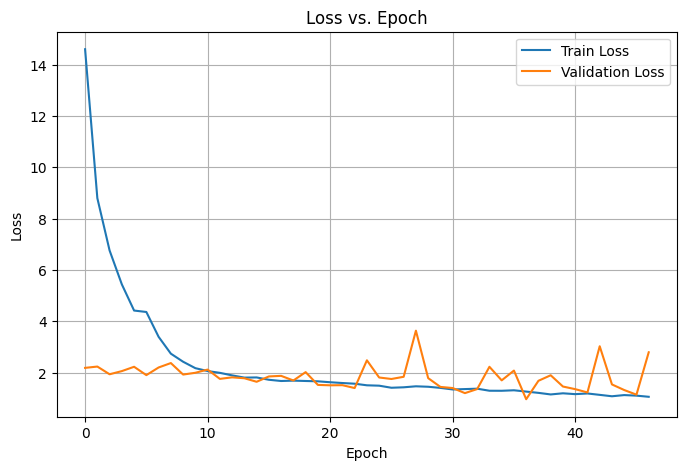

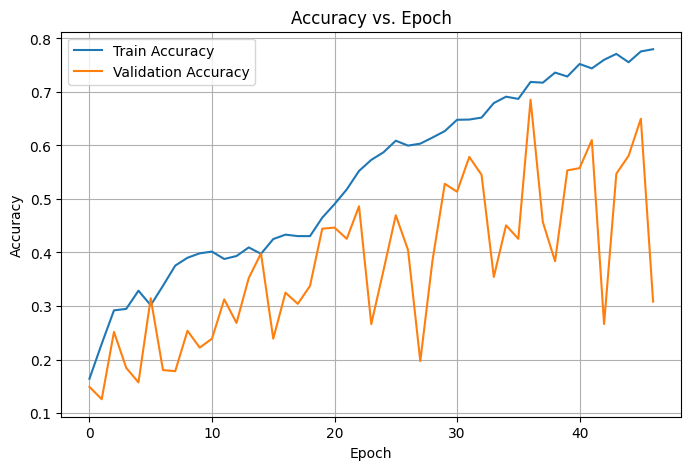

In [6]:
##model without dropout
# model = ResNet50BiLSTMAttention(classes=num_languages)
#model with dropout
model = ResNet34BiLSTMAttentionDropout(classes=num_languages, dropout_prob=0.2)
trainer = Trainer(model, train_loader, valid_loader, test_loader, num_classes = num_languages, num_epochs=50, gradual_unfreezing=False, unfreeze_epochs=[2, 4, 6], patience=10)
trainer.train()
trainer.plot_losses()
trainer.plot_accuracies()

In [ ]:
# #For retraining
# resume_epoch = 9
# # train for x more epochs
# number_to_train = 1
# #Make sure the model is set to the one you want to use
# model = ResNet50BiLSTMAttention(classes=num_languages)
# checkpoint_path = os.path.join("checkpoints", model.__class__.__name__, f"model_epoch_{resume_epoch}.pt")
# model.load_state_dict(torch.load(checkpoint_path))

# trainer = Trainer(
#     model=model,
#     train_loader=train_loader,
#     valid_loader=valid_loader,
#     test_loader=test_loader,
#     num_classes=num_languages,
#     num_epochs=number_to_train,  # train for 5 more epochs
#     gradual_unfreezing=False
# )
# trainer.train(start_epoch=resume_epoch)

Mode: train Shape: torch.Size([128, 1, 128, 241])
ResNet Layer conv1 Output Shape: torch.Size([128, 64, 64, 121])
ResNet Layer bn1 Output Shape: torch.Size([128, 64, 64, 121])
ResNet Layer relu Output Shape: torch.Size([128, 64, 64, 121])
ResNet Layer maxpool Output Shape: torch.Size([128, 64, 32, 61])
ResNet Layer layer1 Output Shape: torch.Size([128, 256, 32, 61])
ResNet Layer layer2 Output Shape: torch.Size([128, 512, 16, 31])
ResNet Layer layer3 Output Shape: torch.Size([128, 1024, 8, 16])
ResNet Layer layer4 Output Shape: torch.Size([128, 2048, 4, 8])
ResNet Layer avgpool Output Shape: torch.Size([128, 2048, 1, 7])
ResNet Output Shape: torch.Size([128, 2048, 1, 7])
ResNet Output Shape after reshaping: torch.Size([128, 7, 2048])
train: tensor([[-2.4922e+00, -2.0183e+00,  2.3698e+00,  ..., -1.3574e+00,
          9.6616e-01,  4.5685e-01],
        [-2.0506e+00, -6.2671e-01,  3.9119e-01,  ..., -1.4927e+00,
         -4.7400e-01,  1.7047e+00],
        [ 1.6306e+00,  1.5857e+00, -2.2036e+

In [8]:
#loading models only
model = ResNet50BiLSTMAttention(classes=num_languages)
def load_best_model(model_dir, model):
        with open(os.path.join(model_dir, "best_model.pkl"), "rb") as f:
            saved_data = pickle.load(f)
            model.load_state_dict(saved_data["model_state"])
            print(f"Best Model Achieved at Epoch: {saved_data['epoch']} with Validation Loss: {saved_data['val_loss']:.4f}")

load_best_model("checkpoints/ResNet50BiLSTMAttention",model)



Best Model Achieved at Epoch: 9 with Validation Loss: 1.6613
